In [2]:
import torch
from torch import nn

In [3]:
# #code to free up gpu
# !pip install GPUtil

# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()         

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# all these numbers and layers are defined in alexnet implementation
alexnet = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 386, kernel_size=3, padding=1),nn.ReLU(),
            nn.Conv2d(386, 386, kernel_size=3, padding=1),nn.ReLU(),
            nn.Conv2d(386, 256, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),nn.Flatten(),
            
            # best way to get this 6400 is after adding flatten just check for the size of tensor returned after flatten layer
            nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
)

In [6]:
X =  torch.randn(1,1,224,224)
X.shape

torch.Size([1, 1, 224, 224])

In [7]:
alexnet(X).detach()

tensor([[-0.0080,  0.0131, -0.0239, -0.0032, -0.0216,  0.0082, -0.0038,  0.0084,
         -0.0071, -0.0044]])

In [8]:
# lets look at each layer

def look_at_net(net, X):
    
    for layer in net:
        X = layer(X)
        print(f' For {layer.__class__.__name__}, shape : {X.shape}')

In [9]:
look_at_net(alexnet, X)

 For Conv2d, shape : torch.Size([1, 96, 54, 54])
 For ReLU, shape : torch.Size([1, 96, 54, 54])
 For MaxPool2d, shape : torch.Size([1, 96, 26, 26])
 For Conv2d, shape : torch.Size([1, 256, 26, 26])
 For MaxPool2d, shape : torch.Size([1, 256, 12, 12])
 For Conv2d, shape : torch.Size([1, 386, 12, 12])
 For ReLU, shape : torch.Size([1, 386, 12, 12])
 For Conv2d, shape : torch.Size([1, 386, 12, 12])
 For ReLU, shape : torch.Size([1, 386, 12, 12])
 For Conv2d, shape : torch.Size([1, 256, 12, 12])
 For ReLU, shape : torch.Size([1, 256, 12, 12])
 For MaxPool2d, shape : torch.Size([1, 256, 5, 5])
 For Flatten, shape : torch.Size([1, 6400])
 For Linear, shape : torch.Size([1, 4096])
 For ReLU, shape : torch.Size([1, 4096])
 For Dropout, shape : torch.Size([1, 4096])
 For Linear, shape : torch.Size([1, 4096])
 For ReLU, shape : torch.Size([1, 4096])
 For Dropout, shape : torch.Size([1, 4096])
 For Linear, shape : torch.Size([1, 10])


In [10]:
# lets get the fashionmnist dataset

from torch.utils.data import Dataset, DataLoader

In [11]:
import pandas as pd
import torchvision.transforms as transforms

df = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv").head()

In [12]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X.shape, y.shape

((5, 784), (5,))

In [13]:
X.iloc[0], y.iloc[0]

(pixel1      0
 pixel2      0
 pixel3      0
 pixel4      0
 pixel5      0
            ..
 pixel780    0
 pixel781    0
 pixel782    0
 pixel783    0
 pixel784    0
 Name: 0, Length: 784, dtype: int64,
 2)

In [14]:
# lets implement some helper functions for training this network



my_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
])

class fashion_dataset(Dataset):
    def __init__(self,data_path="../input/fashionmnist/fashion-mnist_train.csv", transforms=my_transforms):
        self.input_df = pd.read_csv(data_path)
        self.len = len(self.input_df)
        self.transform = transforms

        self.x  = torch.from_numpy(self.input_df.iloc[:,1:].values)
        self.x = self.x.reshape(self.x.size(0), 1, 28,28).float()
        
        self.y = torch.from_numpy(self.input_df.iloc[:,0].values).long()
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        x_item = self.x[index]
        y_item = self.y[index]
        
        if (self.transform):
            x_item = self.transform(x_item)
               
        return x_item, y_item  
        

In [15]:
train_dataset = fashion_dataset()

torch.Size([1, 224, 224]) tensor(2)
tensor(2)


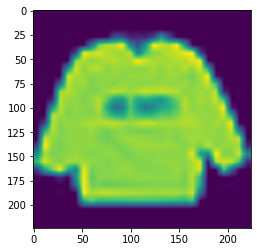

In [16]:
X, y = train_dataset[0]

print(X.shape, y)

import matplotlib.pyplot as plt

print(y)

img = X.permute(1,2,0)
plt.imshow(img)

In [17]:
test_dataset = fashion_dataset(data_path="../input/fashionmnist/fashion-mnist_test.csv")

In [18]:
batch_size=224
train_dataloader = DataLoader(train_dataset, batch_size=128,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=128, shuffle=False)

In [19]:
# helper function to make training easy

def accuracy(y_hat,y):
    return (y_hat.argmax(1)==y).sum()

In [20]:
def full_accuracy(net, data_iter):
    net.eval()
#     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'
    net = net.to(device)
    
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)

            total_acc += accuracy(y_hat, y)
            total_num += y.numel()
    
    return acc_value/total_num
            

In [21]:
def train_net(net, train_dataloader, test_dataloader, lr, num_apochs=10):
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f'training on {device}')
    net.train()
    
    net.to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        acc_value = 0
        total_number = 0
        loss_value = 0
        for X,y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            
            y_hat = net(X)
            l = loss(y_hat, y)
            loss_value += l
            acc_value += accuracy(y_hat, y)
            total_number += y.numel()
        
        with torch.no_grad():
            
            print("\tStatistics:")
            print(f'\tcurrent train loss : {float(total_loss/total_number)}')
            print(f'\tcurrent train acc : {float(acc_value/total_number)}')
            print(f'\tcurrent test acc : {float(full_accuracy(net, test_dataloader))}')
    
            
            train_loss.append(float(total_loss/total_number))
            test_acc.append(float(full_accuracy(net, test_dataloader)))
            train_acc.append(float(acc_value/total_number))
    
    plt.plot(range(num_epochs), train_loss, label = 'train loss')
    plt.plot(range(num_epochs), train_acc, label = 'train acc')
    plt.plot(range(num_epochs), test_acc, label = 'test acc')
    plt.grid(True)
    plt.legend()
    plt.show()
            
        

In [22]:
%%time
lr , num_epochs = 0.01, 10
train_net(alexnet, train_dataloader, test_dataloader, num_epochs, lr)

training on cuda


RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 15.90 GiB total capacity; 14.90 GiB already allocated; 63.75 MiB free; 15.04 GiB reserved in total by PyTorch)

hmm I wonder how to makeit work!